# Starbucks Capstone Challenge

## Section 1: Business Understanding

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Import required packages:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Section 2: Data Exploration

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Read in the datasets:

In [3444]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Create a function to summarize the details of each dataset:

In [3445]:
# Define a function to answer: How large is the dataset? How many null values are there? What proportion of nulls? What are the column types?
def df_info(df):
    '''
    Determine the size and shape of the dataset, the number and proportion of null values in each column, and the data type in each column.
    ARGS: 
    df - dataframe of interest
    OUTPUTS: 
    A string containing the Shape of the dataframe followed by a line for each column containing the 
    column name: number of null values, proportion of null values, and column type.
    '''
    print("Head:")
    print(df.head())
    print()
    print("Shape: " + "\n" + str(df.shape))
    print()
    print("Column Info:")
    for column in df.columns:
        num_null = df[column].isnull().sum()
        prop_null = df[column].isnull().mean()
        col_type = df[column].dtype
        try:
            nunique = df[column].nunique()
        except TypeError:
            nunique = 'cannot compute for this data type'
        print("    " + column + "\n" + "        " + str(num_null) + " nulls, proportion of nulls = " + 
              str(prop_null) + ", type = " + str(col_type) + ", nunique = " + str(nunique))
    print("\n" + "Descriptive Statistics:")
    print(df.describe())

### Portfolio:

In [3446]:
df_info(portfolio) # Use the df_info function to determine the size and contents of the portfolio dataset

Head:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  

Shape: 
(10, 6)

Column Info:
    reward
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 5
    channels
        0 nulls, proportion of nulls = 0.0, type = object, nunique = cannot compute for this data type
    difficulty
        0 nulls, proportion of nulls = 0.0

**Comment:** There are only 10 rows (offers) and 6 columns (reward, channels, difficulty, duration, offer_type, and id). There are no null values. Descriptive statistics do not provide much insight for this dataset.

In [3447]:
# portfolio.value_counts()

**Comment:** The above line of code throws an error, because the 'channels' column is a list indicating how an offer was distributed. We will address this in Section 3: Data Preparation. For now, let's exclude 'channels' from our value_counts() function. We will also exclude 'id' since each of the 10 offers has a unique 'id'.

In [3448]:
portfolio[['reward', 'difficulty', 'duration', 'offer_type']].groupby('offer_type').value_counts()

offer_type     reward  difficulty  duration
bogo           5       5           5           1
                                   7           1
               10      10          5           1
                                   7           1
discount       2       10          7           1
                                   10          1
               3       7           7           1
               5       20          10          1
informational  0       0           3           1
                                   4           1
Name: count, dtype: int64

**Comment:** Each offer is unique/distinct. None of them have the same reward, difficulty, and duration, though some share reward and difficulty amounts.

**Question to Visualize:** Do higher difficulty offers also tend to have a higher reward?

Text(0, 0.5, 'Reward ($)')

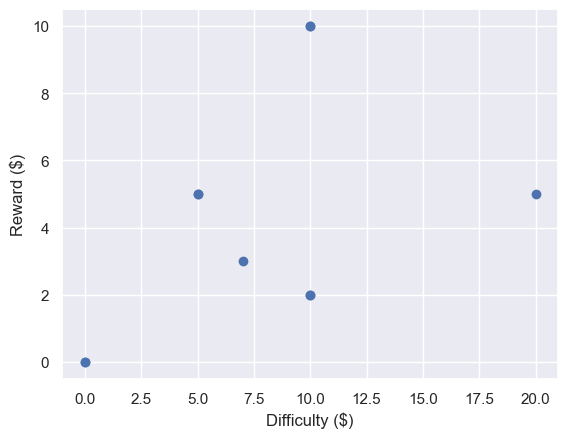

In [3449]:
plt.scatter(portfolio['difficulty'], portfolio['reward']);
plt.xlabel('Difficulty ($)')
plt.ylabel('Reward ($)')

**Answer:** A weak positive correlation exists between offer difficulty and offer reward. However, there are only 10 offers in the dataset. It is unlikely customers would complete offers with high difficulty and low reward, so this makes sense contextually. 

__*Items to Address in Section 3: Data Preparation*__

1. *Format all columns to 'offer_{}' where {} is the original column name. E.g. 'reward' becomes 'offer_reward'. The goal is to avoid having duplicate column names containing different data across datasets.*
2. *Convert 'channels' column from a list to binary categorical columns.*

### Profile:

In [3450]:
df_info(profile) # Use the df_info function to determine the size and contents of the profile dataset

Head:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

Shape: 
(17000, 5)

Column Info:
    gender
        2175 nulls, proportion of nulls = 0.12794117647058822, type = object, nunique = 3
    age
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 85
    id
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 17000
    became_member_on
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 1716
    income
        2175 nulls, proportion of nulls = 0.12794117647058822, type = float64, nunique = 91

Descriptive Statistics:
                age 

**Comment:** There are 17,000 rows and unique IDs, indicating no duplicate rows. There are 2,175 nulls in both the 'gender' and 'income' columns. It is worth noting there are three unique 'gender' entries, not just male (M) and female (F). The maximum age is 118. It seems unlikely, though not necessarily impossible, that a 118 year-old-person would be using the Starbucks app. Additionally, the mean age is 62.5 while the median is 58, so age is likely a right-skewed distribution. We will need to check for and address any outliers. Similarly, the mean income is $65,405 while the median is $64,000, suggesting that this is also a right-skewed distribution with potential outliers on the high end. Finally, 'became_member_on' is being handled as an integer, when it should, in fact, be in datetime format. 

**Follow-Up Question:** Given that both 'gender' and 'income' have 2,175 null values, is it the same users with null values in both fields or different users with null values in one field or the other?

In [3451]:
nulls = profile[profile[['gender', 'income']].isnull().all(axis=1)]
print(nulls.shape)
nulls.head()

(2175, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


**Answer:** The same 2,175 users have null 'gender' and 'income'.

**Follow-Up Question:** Interestingly, the first five users in this "null" population also have an age of 118. Do all 2,175 people with null 'gender' and 'income' have an 'age' of 118?

First, let's **visualize** the age distribution:

Text(0, 0.5, 'Frequency')

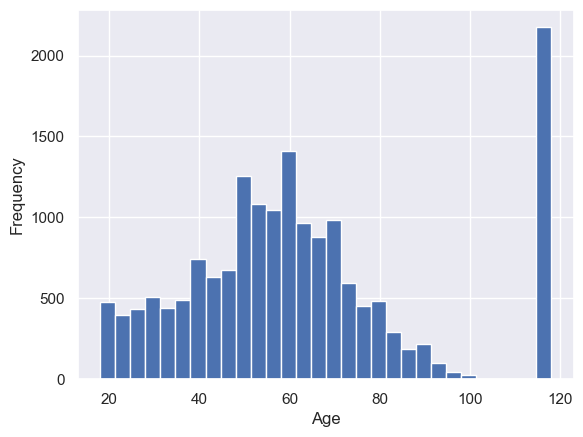

In [3452]:
plt.hist(profile['age'], bins=30)
plt.xlabel('Age')
plt.ylabel('Frequency')

**Comment:** The highest frequency is around age 118 with more than 2,000 occurences. Given how few people in the world are 118 years old and subsequently how few of them would use the Starbucks app, we can be fairly certain this data is inaccurate. Of the reasonable ages reported, the largest number of users appear to be in the 50-60 year old range. As we know from above, the average age is skewed upwards to 62.5 while the median is 58. 

**Follow-Up Question:** Exactly how many users listed 'age' as 118?

In [3453]:
(profile['age']== 118).sum()

np.int64(2175)

**Answer:** There are exactly 2,175 of 'age' 118. That's the same number of users with null 'gender' and 'income'.

**Follow-Up Question:** Is it the same 2,175 users?

In [3454]:
((profile['age']== 118) & (profile[['gender', 'income']].isnull().all(axis=1))).sum()

np.int64(2175)

**Answer:** Yes! The same 2,175 users with null 'gender' and 'income' have an 'age' of 118. 

**Comment:** Perhaps these users generally prefer to report as little data as possible to maintain privacy. Alternatively, if the app has age limits (e.g. users must be 18 or older), these may be underage users skirting those restrictions by lying about their age. Either way, these users clearly have not shared their real information for whatever reason. Since there are no null values in the 'age' column, users must be required to provide an age. If 'age' were not required, these users would likely have null 'age' values rather than 118.

**Follow-Up Questions:** 
1. What are the age ranges allowed in the app and are users required to provide an age? If required to provide an age, is it required for data collection and/or legal reasons? If not against the law, would it make sense for the developers to allow users to register without providing an age if they so choose?
2. How does a user's willingness to complete their profile accurately relate to their likelihood to engage with offers? 

We will look at these "null" profiles more closely in Section 3: Data Preparation. 

**Question to Visualize:** How many users are there in each gender group?

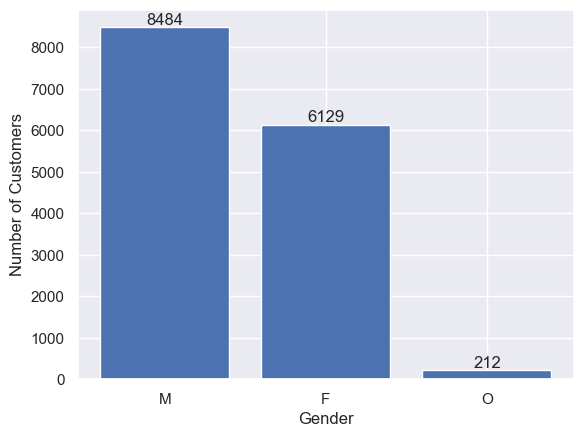

In [3455]:
gender_counts = profile['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
for i in range(len(gender_counts.index)):
    plt.text(i, gender_counts.values[i], str(gender_counts.values[i]), ha='center', va='bottom')

**Answer:** There are 8,484 male (M) users, 2,355 more than the 6,129 female (F) users. Only 212 users  identify as other (O).

**Question to Visualize:** What is the distribution of user incomes?

Text(0, 0.5, 'Number of Customers')

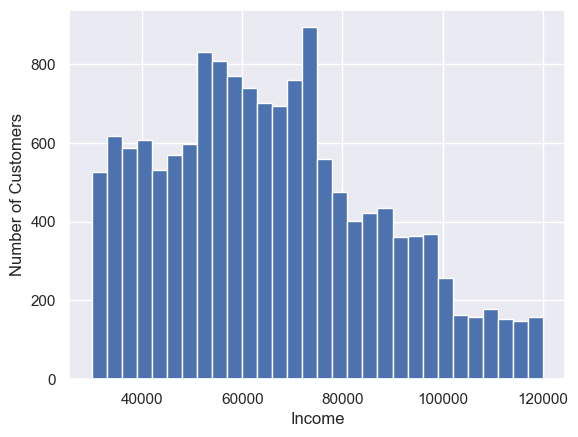

In [3456]:
plt.hist(profile['income'], bins=30)
plt.xlabel('Income')
plt.ylabel('Number of Customers')

**Answer:** Most users make less than $80,000 and there are no obvious outliers here. The highest frequency 'income' appears to be somewhere around $75,000. From above, we know that the average income is $65,405 with a minimum of $30,000, a maximum of $120,000, and a median of $64,000. 

**Follow-Up Question:** What is the mode?

In [3457]:
profile['income'].mode()

0    73000.0
Name: income, dtype: float64

**Answer:** The mode is $73,000.

__*Items to Address in Section 3: Data Preparation*__

1. *Rename 'id' to 'customer_id' for clarity.*
2. *Convert 'became_member_on' from int to datetime and extract year and month as additional columns.*
3. *Split the 2,175 "null" profiles into a separate dataframe for analysis and comparison to the "complete" profiles.*

### Transcript:

In [3458]:
df_info(transcript) # Use the df_info function to determine the size and contents of the transcript dataset

Head:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  

Shape: 
(306534, 4)

Column Info:
    person
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 17000
    event
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 4
    value
        0 nulls, proportion of nulls = 0.0, type = object, nunique = cannot compute for thi

**Comment:** There are 306,534 rows representing each 'event' (transaction, offer received, offer viewed, offer completed) by each individual user and four columns (person, event, value, and time). Value is a dictionary, which will need to be reformatted later for easier handling. The 'person' column contains the id for the customer completing each 'event'. There are no null values in this dataset. The average 'time' from test start for an 'event' is 366 hours, but the median is 408 hours. 

In [3459]:
# transcript.value_counts()

**Comment:** The above line of code throws an error, because the 'value' field is a dictionary. We will address this in Section 3: Data Preparation. For now, let's exclude 'value' from our value_counts() function. Instead, let's focus on 'event' and 'time' since 'person' has 17,000 unique values corresponding to the 17,000 unique users.

In [3460]:
events = transcript['event'].value_counts()
times = transcript['time'].value_counts().sort_index()
print(events, times)

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64 time
0      15561
6       2506
12      2215
18      2015
24      1921
       ...  
690     1260
696     1326
702     1115
708     1048
714     1130
Name: count, Length: 120, dtype: int64


**Comment:** The value counts for 'time' are not easy to interpret in this format. The 'event' counts make it easy to see that there are many more transactions than offers received, viewed, or completed.

**Visualize** the 'event' counts:

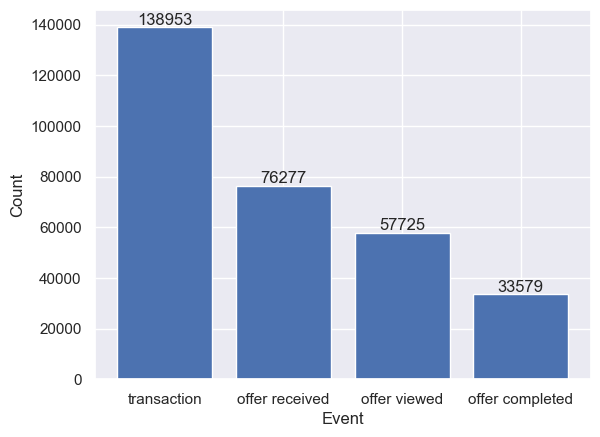

In [3461]:
plt.bar(events.index, events.values)
plt.xlabel('Event')
plt.ylabel('Count')
for i in range(len(events.index)):
    plt.text(i, events.values[i], str(events.values[i]), ha='center', va='bottom')

**Comment:** There are significantly more transactions than offers received, viewed, and completed. This is in line with what we would expect given that many users will buy regardless of potential offers. 

Text(0, 0.5, 'Count')

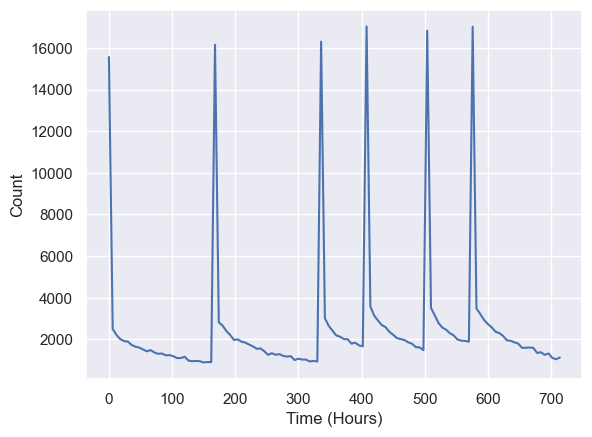

In [3462]:
plt.plot(times.index, times.values)
plt.xlabel('Time (Hours)')
plt.ylabel('Count')

**Comment:** There are spikes in the number of events for certain times (0, ~180, ~320, ~400, ~500, and ~580).

**Follow-Up Question:** Do these spikes coincide with when offers were received?

In [3463]:
offers_received = transcript[transcript['event'] == 'offer received']
offers_received.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


(0.0, 14778.0)

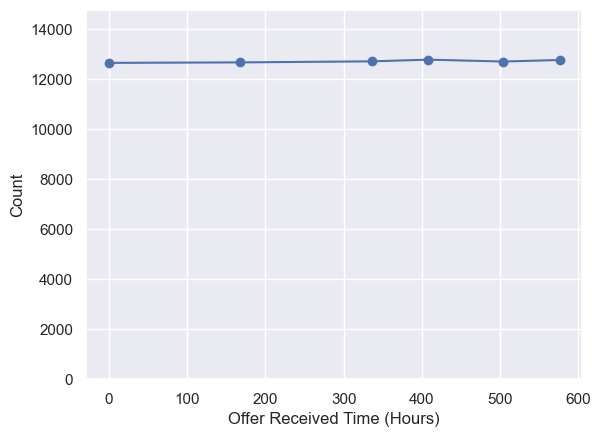

In [3464]:
or_times = offers_received['time'].value_counts().sort_index()
plt.plot(or_times.index, or_times.values, marker = 'o')
plt.xlabel('Offer Received Time (Hours)')
plt.ylabel('Count')
plt.ylim(0, max(or_times) + 2000)

**Answer:** Yes, the spikes correspond to when offers were received. However, offer received does not account for the total count at the highest points, so we know that there are other events going on when the offers are received. It's possible that some users view the offers as soon as they're received. 

__*Items to Address in Section 3: Data Preparation*__

1. *Rename 'person' column to 'customer_id' to match field name in the profile dataframe.*
2. *Convert 'value' column from dictionary to single value columns.*

## Section 3: Data Preparation

### Portfolio:

__*Items to Address*__

1. *Format all columns to 'offer_{}' where {} is the original column name. E.g. 'reward' becomes 'offer_reward'. The goal is to avoid having duplicate column names containing different data across datasets.*
2. *Convert 'channels' column from a list to binary categorical columns.*

**Task #1:** Rename fields to reflect these are characteristics of the offer to prevent confusion later on.

In [3465]:
portfolio = portfolio.rename(columns = {'id': 'offer_id', 'reward': 'offer_reward', 'difficulty': 'offer_difficulty', 'duration': 'offer_duration'})

**Follow-Up:** Let's create an 'offer_desc' field that is more interpretable than the 'offer_id' for visualizations. We'll also create a simple float version of 'offer_id'.

In [3466]:
portfolio['offer_desc'] = (portfolio['offer_type'] + ': ' + portfolio['offer_reward'].astype('str') + '_' + 
                           portfolio['offer_difficulty'].astype('str') + '_' + portfolio['offer_duration'].astype('str'))

oids = portfolio['offer_id'].unique().tolist()
oid_mapping = dict(zip(oids,range(len(oids))))
portfolio['offer_id_num'] = portfolio['offer_id'].map(oid_mapping)

portfolio.head(10)

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,offer_desc,offer_id_num
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo: 10_10_7,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo: 10_10_5,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,informational: 0_0_4,2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo: 5_5_7,3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount: 5_20_10,4
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount: 3_7_7,5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount: 2_10_10,6
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational: 0_0_3,7
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo: 5_5_5,8
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount: 2_10_7,9


**Task #2:** Convert 'channels' column from a list to binary categorical columns representing each component of the list. This will make this categorical information easier to work with and use in modeling. 

In [3467]:
# Explode the list into rows
portfolio_exploded = portfolio.explode('channels')

# Create dummy variables (binary columns)
portfolio_dummies = pd.get_dummies(portfolio_exploded, columns=['channels'], prefix='', prefix_sep='')

# Aggregate back to original rows, keeping max value (1 if present, 0 if not)
portfolio_new = portfolio_dummies.groupby(portfolio_dummies.index).max()

# Print result
print(portfolio_new)

   offer_reward  offer_difficulty  offer_duration     offer_type  \
0            10                10               7           bogo   
1            10                10               5           bogo   
2             0                 0               4  informational   
3             5                 5               7           bogo   
4             5                20              10       discount   
5             3                 7               7       discount   
6             2                10              10       discount   
7             0                 0               3  informational   
8             5                 5               5           bogo   
9             2                10               7       discount   

                           offer_id            offer_desc  offer_id_num  \
0  ae264e3637204a6fb9bb56bc8210ddfd         bogo: 10_10_7             0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0         bogo: 10_10_5             1   
2  3f207df678b143eea3cee63

### Profile:

__*Items to Address*__

1. *Rename 'id' to 'customer_id' for clarity.*
2. *Convert 'became_member_on' from int to datetime and extract year and month as additional columns.*
3. *Split the 2,175 "null" profiles into a separate dataframe for analysis and comparison to the "complete" profiles.*

**Task #1:** Rename 'id' to 'customer_id' for clarity. 

In [3468]:
profile = profile.rename(columns = {'id': 'customer_id'})

**Task #2:** Reformat 'became_member_on' from an integer to a datetime field. 

In [3469]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

**Visualize** membership join dates:

In [3470]:
# Extract the full date (YYYY-MM-DD), year-month (YYYY-MM), and month (MM)
profile['member_join_year'] = profile['became_member_on'].dt.strftime('%Y')
profile.head()

,gender,age,customer_id,became_member_on,income,member_join_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017


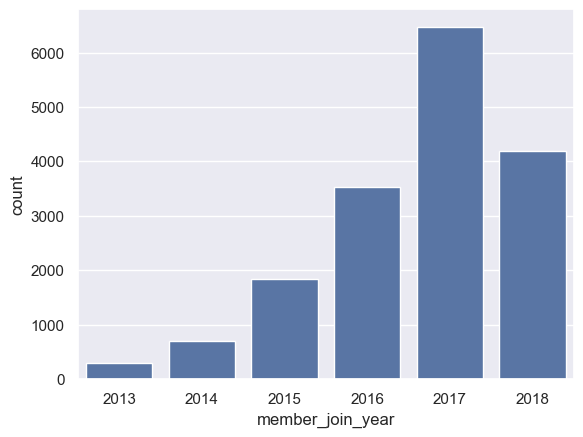

In [3471]:
sns.countplot(data = profile, x = 'member_join_year', order = profile.sort_values(['member_join_year'], ascending=True).set_index('member_join_year').index);

**Comment:** New memberships increased year over year from 2013 to a peak in 2017, followed by fewer new members in 2018. 

**Task #3:** Create a dataframe by extracting the user profiles with null 'gender' and 'income' and 'age' 118.

In [3472]:
null_profiles = profile[(profile['age']== 118) & (profile['gender'].isnull()) & (profile['income'].isnull())]
df_info(null_profiles)

Head:
  gender  age                       customer_id became_member_on  income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12     NaN   
4   None  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04     NaN   
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586       2017-09-25     NaN   
7   None  118  68617ca6246f4fbc85e91a2a49552598       2017-10-02     NaN   

  member_join_year  
0             2017  
2             2018  
4             2017  
6             2017  
7             2017  

Shape: 
(2175, 6)

Column Info:
    gender
        2175 nulls, proportion of nulls = 1.0, type = object, nunique = 0
    age
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 1
    customer_id
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 2175
    became_member_on
        0 nulls, proportion of nulls = 0.0, type = datetime64[ns], nunique = 950
    income
        2175

**Follow-Up:** Let's also create a dataframe containing only the users with complete profiles.

In [3473]:
complete_profiles = profile[(profile['gender'].notnull()) & (profile['income'].notnull())]
df_info(complete_profiles)

Head:
   gender  age                       customer_id became_member_on    income  \
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0   
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0   
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0   

   member_join_year  
1              2017  
3              2017  
5              2018  
8              2018  
12             2017  

Shape: 
(14825, 6)

Column Info:
    gender
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 3
    age
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 84
    customer_id
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 14825
    became_member_on
        0 nulls, proportion of nulls = 0.0, type = datetime64[ns], nunique = 170

**Finally**, let's create a simple float version of customer_id.

In [3474]:
cids = profile['customer_id'].unique().tolist()
cid_mapping = dict(zip(cids,range(len(cids))))
profile['customer_id_num'] = profile['customer_id'].map(cid_mapping)

profile.head(10)

,gender,age,customer_id,became_member_on,income,member_join_year,customer_id_num
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,1
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,3
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,4
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,5
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,6
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,7
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,8
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN,2016,9


### Transcript:

__*Items to Address*__

1. *Rename 'person' column to 'customer_id' to match field name in the profile dataframe.*
2. *Convert 'value' column from dictionary to single value columns.*

**Task #1:** Rename 'person' to 'customer_id' to align with the profile dataframe. 

In [3475]:
transcript = transcript.rename(columns = {'person': 'customer_id'})

**Task #2:** Convert 'value' from a dictionary into more usable columns. 

*First*, notice that the dictionary has two different keys indicating the same thing: 'offer id' and 'offer_id'. Let's correct the keys so that there is only one version: 'offer_id'. 

In [3476]:
# Function to correct the key 'offer id' to 'offer_id'
def correct_key(dictionary):
    if 'offer id' in dictionary:
        dictionary['offer_id'] = dictionary.pop('offer id')
    return dictionary

In [3477]:
# Apply the function to the dictionary column
transcript['value'] = transcript['value'].apply(correct_key)

*Second*, let's expand the dictionary 'value' column into multiple columns representing each key and the respective values. We will keep the original 'value' column for reference for the time being. 

In [3478]:
# Function to expand dictionary into columns
def expand_dict_columns(df, column_name):
    new_cols = df[column_name].apply(pd.Series)
    df = pd.concat([df, new_cols], axis=1)
    #df = df.drop(column_name, axis=1)
    return df

# Expand the 'details' column
transcript_new = expand_dict_columns(transcript, 'value')

# Display the modified DataFrame
transcript_new

,customer_id,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53,NaN


**Follow-Up:** Rename 'reward' to 'reward_earned' to differentiate from 'offer_reward' in the portfolio_new dataframe. Rename 'amount' to 'amount_spent' for clarity.

In [3479]:
transcript_new = transcript_new.rename(columns = {'reward': 'reward_earned', 'amount': 'amount_spent'})
transcript_new.head() # confirm change was successful

,customer_id,event,value,time,offer_id,amount_spent,reward_earned
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


**Follow-Up:** Drop the 'value' column now that we've confirmed the dictionary was successfully converted into key fields containing the corresponding values. 

In [3480]:
transcript_new = transcript_new.drop(['value'], axis = 1)
transcript_new.head() # confirm change was successful

,customer_id,event,time,offer_id,amount_spent,reward_earned
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Combine Dataframes:

**Merge** portfolio_new, profile / null_profiles / complete_profiles, and transcript_new into one dataframe for (1) all users, (2) users with null profiles, and (3) users with complete profiles.

**1. All Users:**

In [3481]:
full_df = pd.merge(transcript_new, profile, how = 'left', on = 'customer_id')
full_df = pd.merge(full_df, portfolio_new, how = 'left', on = 'offer_id')
df_info(full_df) # Confirm merges were successful

Head:
                        customer_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount_spent  reward_earned gender  age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9           NaN            NaN      F   75   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN            NaN   None  118   
2  2906b810c7d4411798c6938adc9daaa5           NaN            NaN      M   68   
3  fafdcd668e3743c1bb461111dcafc2a4           NaN            NaN   None  118   
4  4d5c57ea9a6940dd891ad53e9dbe8da0           NaN            NaN   None  118   

  became_member_on    income  ... offer_reward  offer_difficulty  \
0       2017-05-09  100000.0  ...          5.0               5.0   
1       20

**Comment:** Merge appears successful. As expected, we have 306,534 rows, which matches the number in the original transcript dataframe. We also have 17,000 unique customer IDs, which matches the number expected.

**2. Users with Null Profiles:**

In [3482]:
null_df = pd.merge(null_profiles, transcript_new, how = 'left', on = 'customer_id')
null_df = pd.merge(null_df, portfolio_new, how = 'left', on = 'offer_id')
df_info(null_df) # Confirm merges were successful

Head:
  gender  age                       customer_id became_member_on  income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
1   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
2   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
3   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
4   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   

  member_join_year           event  time                          offer_id  \
0             2017  offer received   168  2906b810c7d4411798c6938adc9daaa5   
1             2017    offer viewed   216  2906b810c7d4411798c6938adc9daaa5   
2             2017  offer received   336  0b1e1539f2cc45b7b9fa7c272da2e1d7   
3             2017    offer viewed   348  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4             2017     transaction   360                               NaN   

   amount_spent  ...  offer_reward  offer_difficulty  offer_duration

**Comment:** Merge appears successful. As expected, we have 2,175 unique customer IDs corresponding to users with null profiles. 

**3. Users with Complete Profiles:**

In [3483]:
complete_df = pd.merge(complete_profiles, transcript_new, how = 'left', on = 'customer_id')
complete_df = pd.merge(complete_df, portfolio_new, how = 'left', on = 'offer_id')
df_info(complete_df) # Confirm merges were successful

Head:
  gender  age                       customer_id became_member_on    income  \
0      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
2      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
3      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
4      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   

  member_join_year           event  time                          offer_id  \
0             2017     transaction    18                               NaN   
1             2017     transaction   144                               NaN   
2             2017  offer received   408  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3             2017  offer received   504  3f207df678b143eea3cee63160fa8bed   
4             2017     transaction   528                               NaN   

   amount_spent  ...  offer_reward  offer_difficulty  of

**Comment:** As expected, we have the remainder of the 306,504 events not accounted for by null profiles (272,762) and the remainder of the 17,000 unique customer IDs not accounted for in the 2,175 null profiles (14,825).

**Follow-Up Question:** What percentage of offers does each type of user (all profiles, null profiles, and complete profiles) complete?

In [3484]:
events_all = full_df['event'].value_counts()
events_null = null_df['event'].value_counts()
events_complete = complete_df['event'].value_counts()

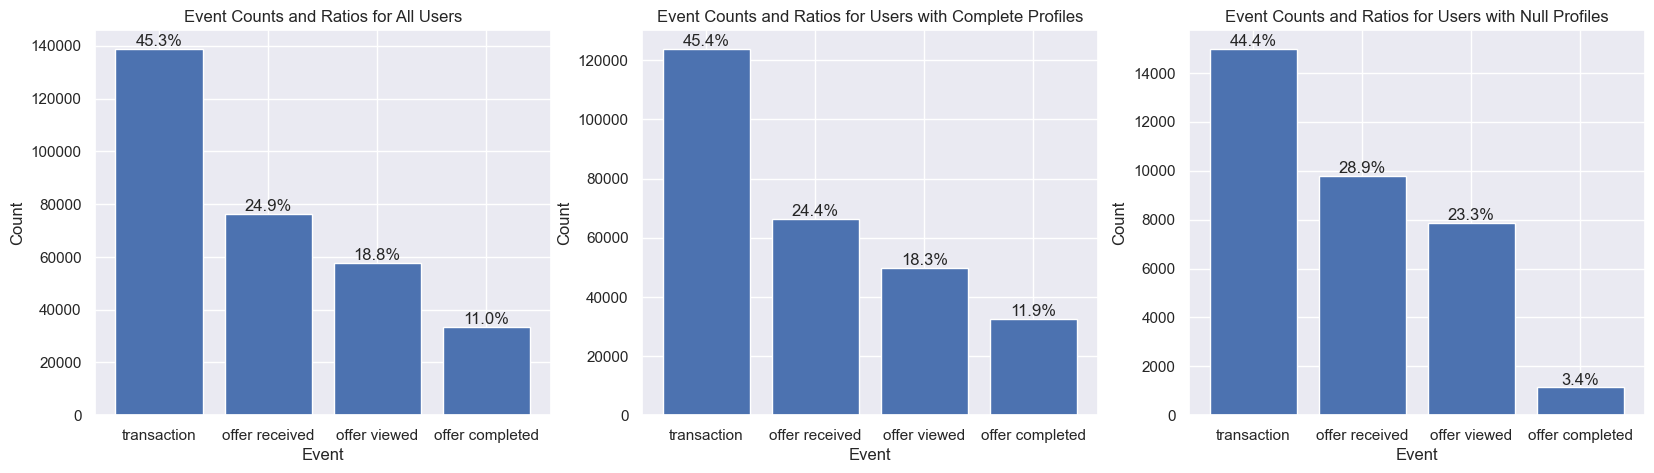

In [3485]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.bar(events_all.index, events_all.values)
plt.xlabel('Event')
plt.ylabel('Count')
plt.title('Event Counts and Ratios for All Users')
for i, value in enumerate(events_all.values):
    ratio = value / events_all.sum()
    plt.text(i, value + 1, f'{ratio:.1%}', ha='center', va='bottom')

plt.subplot(1, 3, 2)
plt.bar(events_complete.index, events_complete.values)
plt.xlabel('Event')
plt.ylabel('Count')
plt.title('Event Counts and Ratios for Users with Complete Profiles')
for i, value in enumerate(events_complete.values):
    ratio = value / events_complete.sum()
    plt.text(i, value + 1, f'{ratio:.1%}', ha='center', va='bottom')

plt.subplot(1, 3, 3)
plt.bar(events_null.index, events_null.values)
plt.xlabel('Event')
plt.ylabel('Count')
plt.title('Event Counts and Ratios for Users with Null Profiles')
for i, value in enumerate(events_null.values):
    ratio = value / events_null.sum()
    plt.text(i, value + 1, f'{ratio:.1%}', ha='center', va='bottom')

**Comment:** Wow! Interestingly, only 3.4% of events for users with null profiles are offer completions, compared to 11.0% for the full user population, and 11.9% for the portion of users with complete profiles. The subset of users with null profiles seems to behave differently than users with complete profiles. This difference in engagement may be important to account for in a model. 

**Follow-Up:** Add a 'profile_complete' flag to full_df to differentiate between complete and null profiles. 

In [3486]:
full_df['profile_complete'] = np.where(full_df['age'] == 118, 0, 1)
full_df.head() # Confirm the new field was added successfully

,customer_id,event,time,offer_id,amount_spent,reward_earned,gender,age,became_member_on,income,...,offer_difficulty,offer_duration,offer_type,offer_desc,offer_id_num,email,mobile,social,web,profile_complete
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,...,5.0,7.0,bogo,bogo: 5_5_7,3.0,True,True,False,True,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-04,NaN,...,20.0,10.0,discount,discount: 5_20_10,4.0,True,False,False,True,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,70000.0,...,10.0,7.0,discount,discount: 2_10_7,9.0,True,True,False,True,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,2017-09-25,NaN,...,10.0,10.0,discount,discount: 2_10_10,6.0,True,True,True,True,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,2017-10-02,NaN,...,10.0,5.0,bogo,bogo: 10_10_5,1.0,True,True,True,True,0


### Additional Questions to Answer Prior to Modeling:

**Question #1:** Which offer occurs the most?

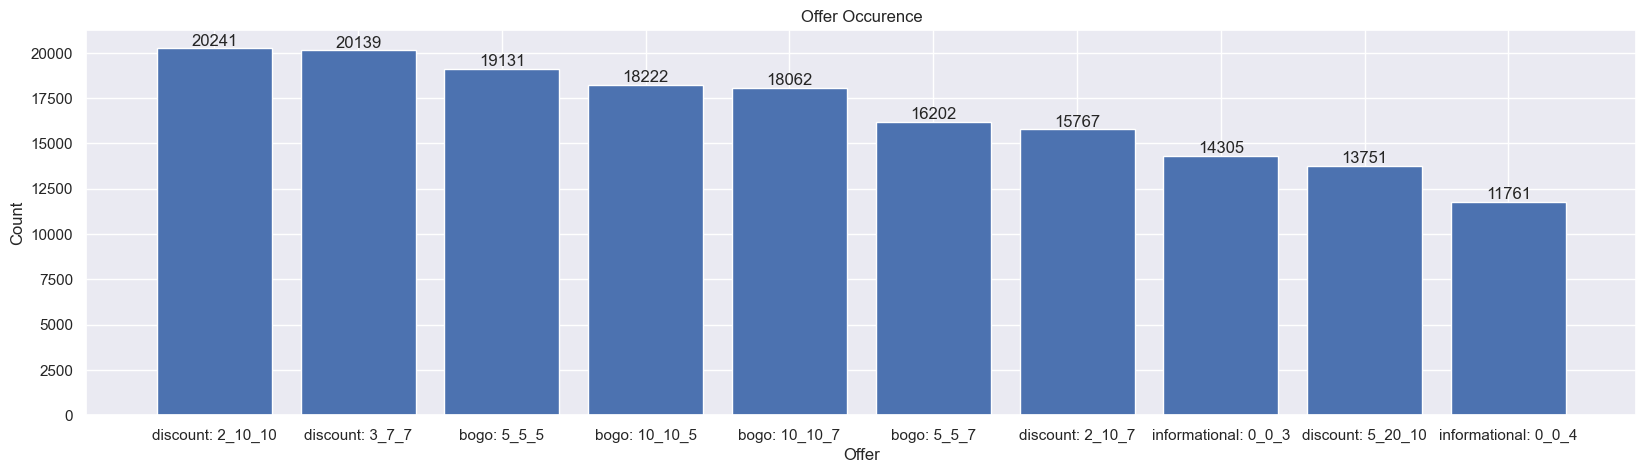

In [3487]:
offer_counts_all = full_df['offer_desc'].value_counts()
plt.figure(figsize=(20, 5))
plt.bar(offer_counts_all.index, offer_counts_all.values)
plt.xlabel('Offer')
plt.ylabel('Count')
plt.title('Offer Occurence')
for i in range(len(offer_counts_all.index)):
    plt.text(i, offer_counts_all.values[i], str(offer_counts_all.values[i]), ha='center', va='bottom')

**Question #2:** Which offer was completed the most?

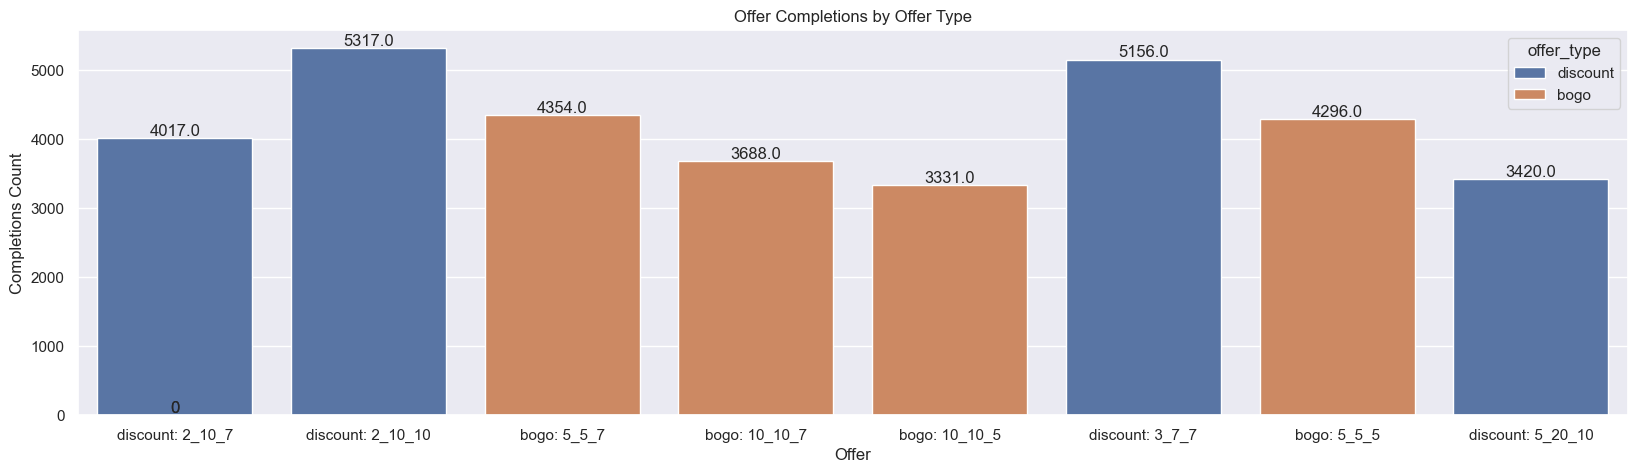

In [3488]:
completed_offers = full_df[full_df['event'] == 'offer completed']
plt.figure(figsize=(20, 5))
ax = sns.countplot(x = 'offer_desc', data = completed_offers, hue = 'offer_type')
plt.xlabel('Offer')
plt.ylabel('Completions Count')
plt.title("Offer Completions by Offer Type")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

**Comment:** Only 8 of the 10 offers were actually completed at all. This makes sense given that two of the offers were informational only.

**Question 3:** What percentage of users who received informational offers actually viewed them?

In [3489]:
informational = full_df[full_df['offer_type'] == 'informational']
print(informational.shape, informational.head())

informational_event_counts = informational['event'].value_counts()
informational_viewed_count = informational_event_counts['offer viewed']
informational_received_count = informational_event_counts['offer received']
informational_viewed_ratio = informational_viewed_count / informational_received_count
informational_viewed_ratio

(26066, 23)                          customer_id           event  time  \
7   2eeac8d8feae4a8cad5a6af0499a211d  offer received     0   
13  c27e0d6ab72c455a8bb66d980963de60  offer received     0   
31  be8a5d1981a2458d90b255ddc7e0d174  offer received     0   
44  a5a6ef2b78a04ddc9f374dd7c7f60bff  offer received     0   
53  6e04a90a0e074496b5f229eb1f553433  offer received     0   

                            offer_id  amount_spent  reward_earned gender  age  \
7   3f207df678b143eea3cee63160fa8bed           NaN            NaN      M   58   
13  3f207df678b143eea3cee63160fa8bed           NaN            NaN      F   78   
31  5a8bc65990b245e5a138643cd4eb9837           NaN            NaN      M   39   
44  5a8bc65990b245e5a138643cd4eb9837           NaN            NaN      M   75   
53  5a8bc65990b245e5a138643cd4eb9837           NaN            NaN      M   27   

   became_member_on   income  ... offer_difficulty  offer_duration  \
7        2017-11-11  51000.0  ...              0.0        

np.float64(0.7109287824089268)

**Answer:** About 71% of the informational offers received by users were actually viewed. 

**Question 4:** What percentage of users who received BOGO and Discount offers actually viewed them? What percentage also completed them?

In [3490]:
bogo = full_df[full_df['offer_type'] == 'bogo']
print(bogo.shape, bogo.head())
bogo_event_counts = bogo['event'].value_counts()
bogo_viewed_count = bogo_event_counts['offer viewed']
bogo_received_count = bogo_event_counts['offer received']
bogo_completed_count = bogo_event_counts['offer completed']
bogo_viewed_ratio = bogo_viewed_count / bogo_received_count
bogo_completed_ratio = bogo_completed_count / bogo_received_count
print(bogo_viewed_ratio, bogo_completed_ratio)

(71617, 23)                          customer_id           event  time  \
0   78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
4   68617ca6246f4fbc85e91a2a49552598  offer received     0   
5   389bc3fa690240e798340f5a15918d5c  offer received     0   
12  4b0da7e80e5945209a1fdddfe813dbe0  offer received     0   
18  ebe7ef46ea6f4963a7dd49f501b26779  offer received     0   

                            offer_id  amount_spent  reward_earned gender  age  \
0   9b98b8c7a33c4b65b9aebfe6a799e6d9           NaN            NaN      F   75   
4   4d5c57ea9a6940dd891ad53e9dbe8da0           NaN            NaN   None  118   
5   f19421c1d4aa40978ebb69ca19b0e20d           NaN            NaN      M   65   
12  ae264e3637204a6fb9bb56bc8210ddfd           NaN            NaN      M   64   
18  9b98b8c7a33c4b65b9aebfe6a799e6d9           NaN            NaN      M   59   

   became_member_on    income  ... offer_difficulty  offer_duration  \
0        2017-05-09  100000.0  ...              5.0      

In [3491]:
discount = full_df[full_df['offer_type'] == 'discount']
print(discount.shape, discount.head())
discount_event_counts = discount['event'].value_counts()
discount_viewed_count = discount_event_counts['offer viewed']
discount_received_count = discount_event_counts['offer received']
discount_completed_count = discount_event_counts['offer completed']
discount_viewed_ratio = discount_viewed_count / discount_received_count
discount_completed_ratio = discount_completed_count / discount_received_count
print(discount_viewed_ratio, discount_completed_ratio)

(69898, 23)                         customer_id           event  time  \
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
6  c4863c7985cf408faee930f111475da3  offer received     0   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received     0   

                           offer_id  amount_spent  reward_earned gender  age  \
1  0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN            NaN   None  118   
2  2906b810c7d4411798c6938adc9daaa5           NaN            NaN      M   68   
3  fafdcd668e3743c1bb461111dcafc2a4           NaN            NaN   None  118   
6  2298d6c36e964ae4a3e7e9706d1fb8c2           NaN            NaN   None  118   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN            NaN      F   61   

  became_member_on   income  ... offer_difficulty  offer_duration  offer_type  \
1       2017-08-04      NaN  ...             20.0          

**Answer:** 83% of bogo offers received were viewed while only about 51% were actually completed. In contrast, 70% of discount offers received were also viewed, with 58% of them being completed. 

**Comment:** Despite a smaller percentage of recipients viewing Discount offers, a greater percentage of users completed Discount offers as compared to BOGO offers. 

**Question 5:** What percentage of total events is attributable to each event and offer type?

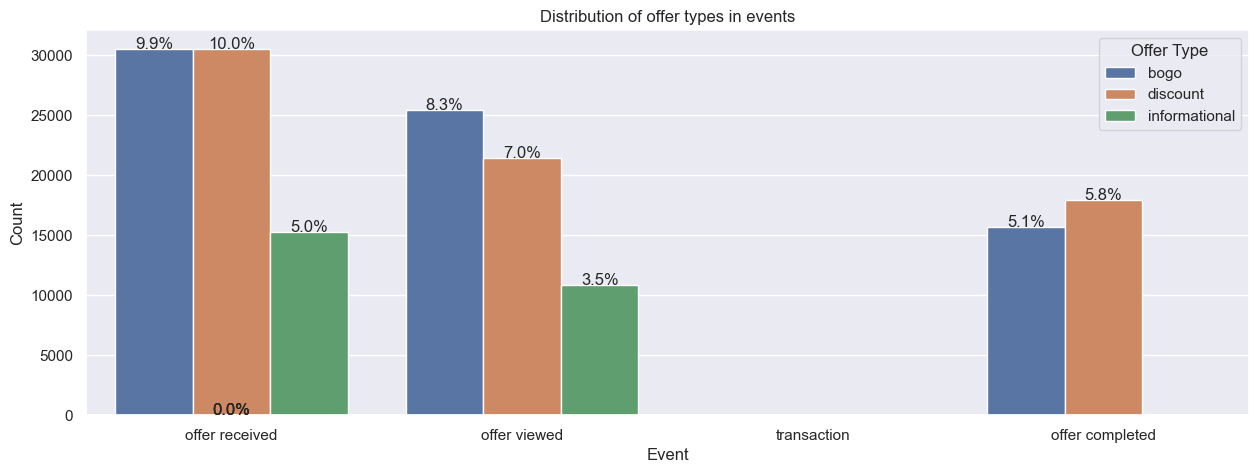

In [3492]:
plt.figure(figsize=(15, 5))
ax2 = sns.countplot(x= "event", hue= "offer_type", data=full_df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    ax2.text(x, y, percentage, ha='center')

**Answer:** More than 45% of total events are attributable to regular transactions. Only 5.1% and 5.8% are attributable to BOGO and Discount offers, respectively. The greater rate of Discount offer completion is interesting considering that a smaller percentage of Discount offers received are viewed compared to BOGO.

**Question 6:** Does one gender take greater advantage of offers than another? Which type of offer is leveraged more by each gender?

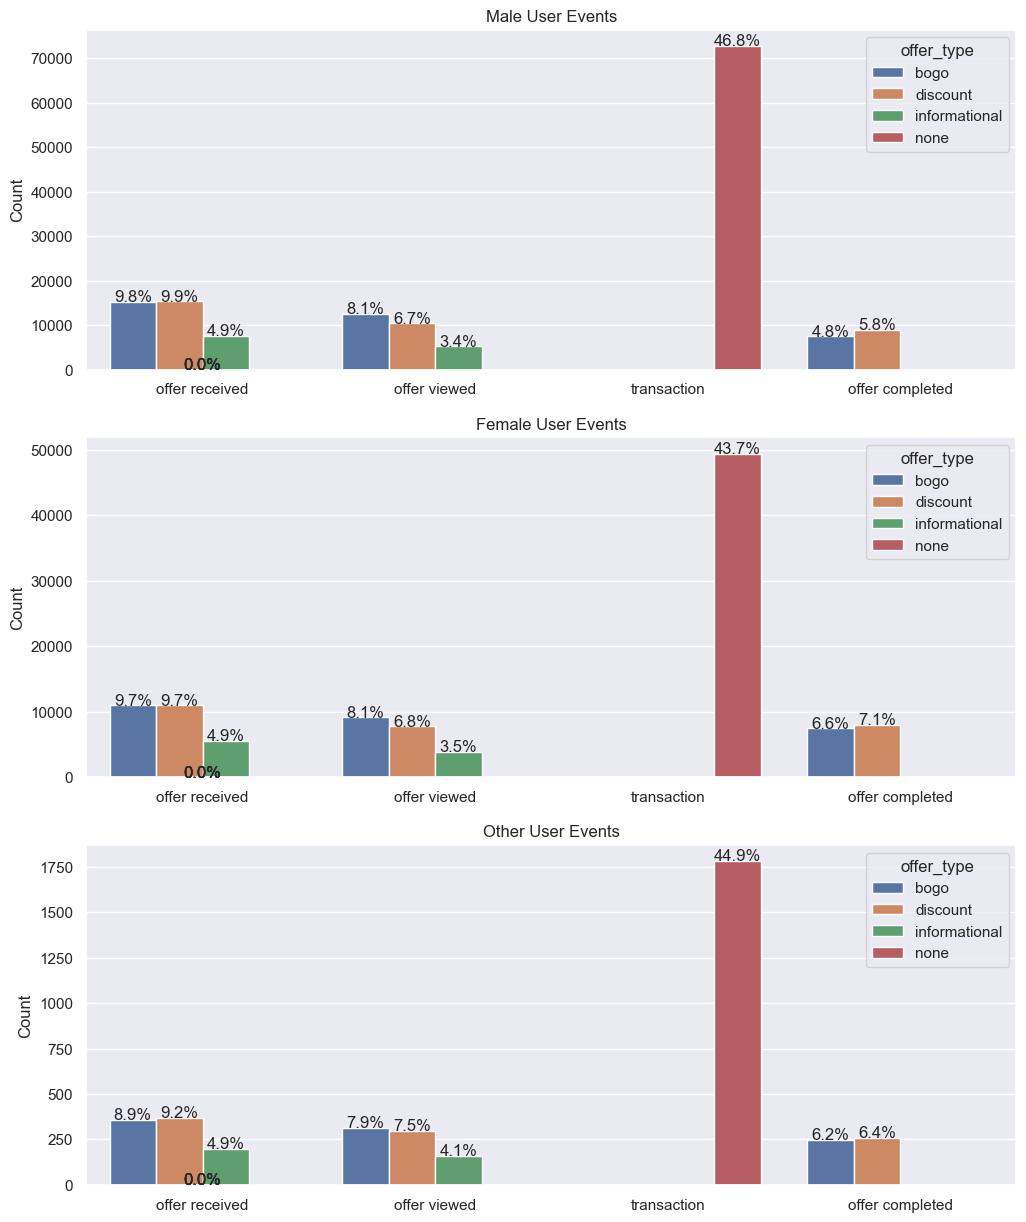

In [3493]:
full_df['offer_type'] = full_df['offer_type'].fillna('none')
male = full_df[full_df['gender'] == 'M']
female = full_df[full_df['gender'] == 'F']
other = full_df[full_df['gender'] == 'O']
hue_order = ['bogo', 'discount', 'informational', 'none']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

m = sns.countplot(x= "event", data=male, hue= "offer_type", ax=axes[0], hue_order=hue_order)
sns.set(style="darkgrid")
axes[0].set_title('Male User Events')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')
male_total = len(male)
for p in m.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/male_total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    m.text(x, y, percentage, ha='center')

#plt.subplot(1, 3, 2)
f = sns.countplot(x= "event", data=female, hue= "offer_type", ax=axes[1], hue_order=hue_order)
sns.set(style="darkgrid")
axes[1].set_title('Female User Events')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('')
female_total = len(female)
for p in f.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/female_total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    f.text(x, y, percentage, ha='center')

#plt.subplot(1, 3, 3)
o = sns.countplot(x= "event", data=other, hue= "offer_type", ax=axes[2], hue_order=hue_order)
sns.set(style="darkgrid")
axes[2].set_title('Other User Events')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('')
other_total = len(other)
for p in o.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/other_total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    o.text(x, y, percentage, ha='center')

**Answer:** Across genders, offer completions make up a higher percentage of all events for female users than male and other gender users: 13.7% total compared to 10.6% and 12.6%, respectively. All gender users complete more discount than BOGO offers. 

**Question 7:** Does one age group take greater advantage of offers than another? Which type of offer is leveraged more by each age group?

**Comment:** We'll use the census age groups, adjusting the lower age ranges into one bracket since the minimum user age is 18. We'll look only at users with complete profiles.

In [3494]:
def assign_age_group(row):
    if row['age'] < 20:
        return '0-19'
    elif (row['age'] >= 20) & (row['age'] < 35):
        return '20-34'
    elif (row['age'] >= 35) & (row['age'] < 50):
        return '35-49'
    elif (row['age'] >= 50) & (row['age'] < 65):
        return '50-64'
    else:
        return '65+'

complete_df['age_group'] = complete_df.apply(assign_age_group, axis=1)

complete_df['age_group'].value_counts().sort_index()

age_group
0-19      3962
20-34    40354
35-49    59335
50-64    92675
65+      76436
Name: count, dtype: int64

In [3495]:
complete_df['offer_type'] = complete_df['offer_type'].fillna('none')

under20_df = complete_df[complete_df['age_group'] == '0-19']
age20to34_df = complete_df[complete_df['age_group'] == '20-34']
age35to49_df = complete_df[complete_df['age_group'] == '35-49']
age50to64_df = complete_df[complete_df['age_group'] == '50-64']
age65up_df = complete_df[complete_df['age_group'] == '65+']

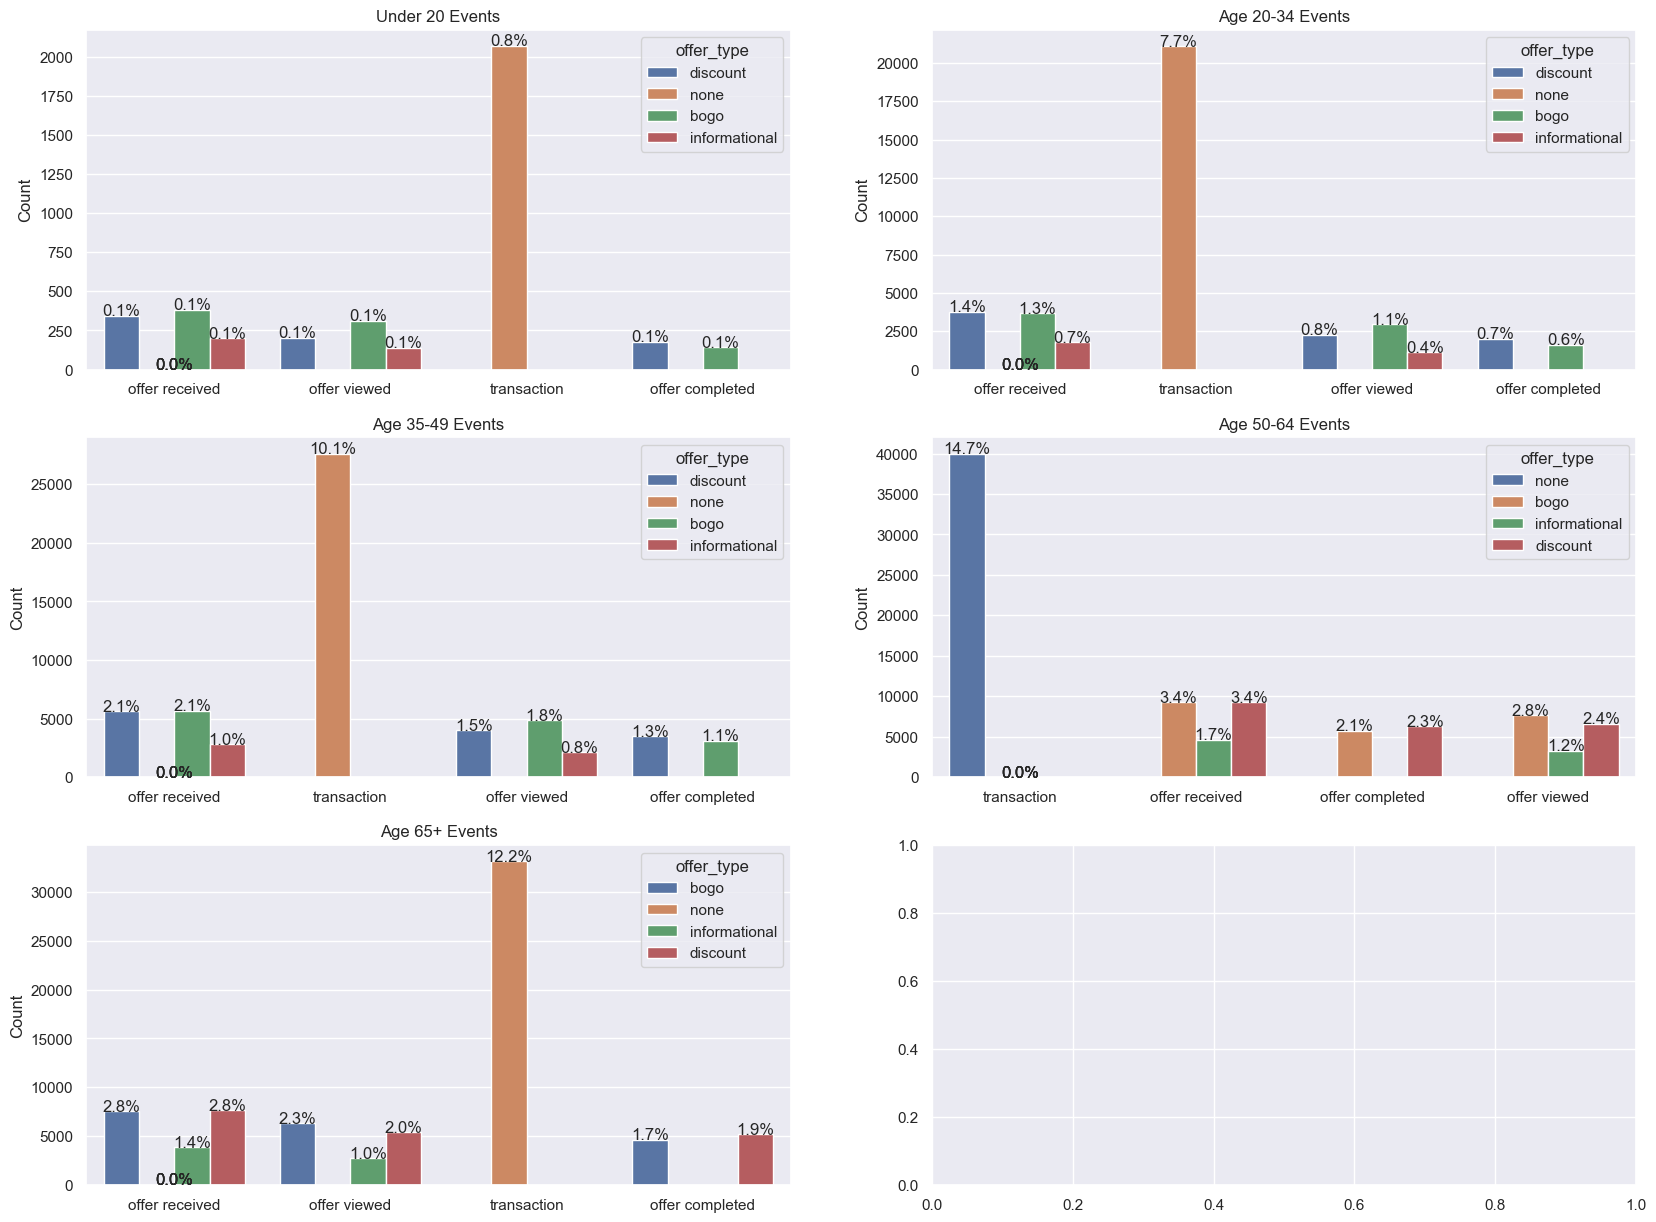

In [3496]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

total_age = len(complete_df)

under20 = sns.countplot(x= "event", data=under20_df, hue= "offer_type", ax=axes[0, 0])
sns.set(style="darkgrid")
axes[0, 0].set_title('Under 20 Events')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('')
for p in under20.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_age)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    under20.text(x, y, percentage, ha='center')

age20to34 = sns.countplot(x= "event", data=age20to34_df, hue= "offer_type", ax=axes[0, 1])
sns.set(style="darkgrid")
axes[0, 1].set_title('Age 20-34 Events')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlabel('')
for p in age20to34.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_age)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    age20to34.text(x, y, percentage, ha='center')

age35to49 = sns.countplot(x= "event", data=age35to49_df, hue= "offer_type", ax=axes[1, 0])
sns.set(style="darkgrid")
axes[1, 0].set_title('Age 35-49 Events')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('')
for p in age35to49.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_age)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    age35to49.text(x, y, percentage, ha='center')

age50to64 = sns.countplot(x= "event", data=age50to64_df, hue= "offer_type", ax=axes[1, 1])
sns.set(style="darkgrid")
axes[1, 1].set_title('Age 50-64 Events')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xlabel('')
for p in age50to64.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_age)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    age50to64.text(x, y, percentage, ha='center')

age65up = sns.countplot(x= "event", data=age65up_df, hue= "offer_type", ax=axes[2, 0])
sns.set(style="darkgrid")
axes[2, 0].set_title('Age 65+ Events')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_xlabel('')
for p in age65up.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_age)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3  # Adjust vertical offset for label position
    age65up.text(x, y, percentage, ha='center')


## Section 4: Data Modeling

### **Goal:** Predict whether a customer will complete an offer or not. 

#### **Modeling Methods to Use:**

1. K-Nearest Neighbors (KNN)
2. Random Forest Classifier
3. Decision Tree Classifier

#### **Process:**

1. Split data into train and test data sets.
2. Train the model.
3. Assess performance. 
4. Tune the model to improve performance.

**Step #1:** Split the data into train and test data sets.

**First**, let's remove rows that don't have an offer ID since we're focusing on offer interactions. I'd like to compare model results across all three of our data cuts, so we'll do this for the full user population, users with null profiles, and users with complete profiles.

In [3497]:
print(full_df.shape)
full_offers_df = full_df.dropna(subset=['offer_id'])
print(full_offers_df.shape, full_offers_df.head())

(306534, 23)
(167581, 23)                         customer_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount_spent  reward_earned gender  age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9           NaN            NaN      F   75   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN            NaN   None  118   
2  2906b810c7d4411798c6938adc9daaa5           NaN            NaN      M   68   
3  fafdcd668e3743c1bb461111dcafc2a4           NaN            NaN   None  118   
4  4d5c57ea9a6940dd891ad53e9dbe8da0           NaN            NaN   None  118   

  became_member_on    income  ... offer_difficulty  offer_duration  \
0       2017-05-09  100000.0  ...              5.0      

In [3498]:
print(null_df.shape)
null_offers_df = null_df.dropna(subset=['offer_id'])
print(null_offers_df.shape, null_offers_df.head())

(33772, 21)
(18776, 21)   gender  age                       customer_id became_member_on  income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
1   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
2   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
3   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
5   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   

  member_join_year           event  time                          offer_id  \
0             2017  offer received   168  2906b810c7d4411798c6938adc9daaa5   
1             2017    offer viewed   216  2906b810c7d4411798c6938adc9daaa5   
2             2017  offer received   336  0b1e1539f2cc45b7b9fa7c272da2e1d7   
3             2017    offer viewed   348  0b1e1539f2cc45b7b9fa7c272da2e1d7   
5             2017  offer received   408  fafdcd668e3743c1bb461111dcafc2a4   

   amount_spent  ...  offer_reward  offer_difficul

In [3499]:
print(complete_df.shape)
complete_offers_df = complete_df.dropna(subset=['offer_id'])
print(complete_offers_df.shape, complete_offers_df.head())

(272762, 22)
(148805, 22)   gender  age                       customer_id became_member_on    income  \
2      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
3      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
5      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
6      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   
7      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   

  member_join_year            event  time                          offer_id  \
2             2017   offer received   408  9b98b8c7a33c4b65b9aebfe6a799e6d9   
3             2017   offer received   504  3f207df678b143eea3cee63160fa8bed   
5             2017  offer completed   528  9b98b8c7a33c4b65b9aebfe6a799e6d9   
6             2017   offer received     0  9b98b8c7a33c4b65b9aebfe6a799e6d9   
7             2017     offer viewed     6  9b98b8c7a33c4b65b9aebfe6a799e6d9   

   amount_spent  ...  offer_di

**Second**, let's fill null values in the complete user population dataset. We'll start with the categorical variable 'gender' and then address 'income' and 'age' 118. We're handling 'age' 118 as null since there are 2,175 users listed as 118. This outlier will wreak havoc on the model if not addressed.

**Replace null values** with the proportion of genders. Instead of filling all 2,175 nulls with the mode, we're going to fill them with the existing proportion of M, F, and O users. 

In [3500]:
print(full_offers_df.gender.value_counts(normalize=True))

probability = list(full_offers_df.gender.value_counts(normalize=True).values)
full_offers_df['gender'] = full_offers_df['gender'].apply(lambda x: np.random.choice(['M', 'F', 'O'], 1, replace=False, p=probability)[0] if pd.isna(x) else x)

print(full_offers_df.gender.value_counts(normalize=True))
full_offers_df['gender'].isnull().sum()

gender
M    0.557078
F    0.428205
O    0.014717
Name: proportion, dtype: float64
gender
M    0.557199
F    0.428062
O    0.014739
Name: proportion, dtype: float64


C:\Users\emma1\AppData\Local\Temp\ipykernel_9052\1888428960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_offers_df['gender'] = full_offers_df['gender'].apply(lambda x: np.random.choice(['M', 'F', 'O'], 1, replace=False, p=probability)[0] if pd.isna(x) else x)


np.int64(0)

**Replace null values** in 'income' using the median since we know the mean has been pulled upward.

In [3501]:
print(full_offers_df['income'].head(), full_offers_df['income'].isnull().sum()) # Look at our starting data and number of nulls
full_offers_df['income'] = full_offers_df['income'].fillna(full_offers_df['income'].median())
print(full_offers_df['income'].head(), full_offers_df['income'].isnull().sum()) # Confirm nulls have been replaced with the median

0    100000.0
1         NaN
2     70000.0
3         NaN
4         NaN
Name: income, dtype: float64 18776
0    100000.0
1     65000.0
2     70000.0
3     65000.0
4     65000.0
Name: income, dtype: float64 0


C:\Users\emma1\AppData\Local\Temp\ipykernel_9052\2551521764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_offers_df['income'] = full_offers_df['income'].fillna(full_offers_df['income'].median())


**Replace null values** with the proportion of ages. Instead of filling all 2,175 nulls with the mode, we're going to fill them with the existing proportion of ages. 

In [3502]:
print(full_offers_df.age.value_counts(normalize=True))

full_offers_df['age'] = full_offers_df['age'].replace(118, np.nan)

print(full_offers_df.age.value_counts(normalize=True))
full_offers_df['age'].isnull().sum()

probability = list(full_offers_df.age.value_counts(normalize=True).values)
age_list = list(full_offers_df.age.value_counts(normalize=True).index)
full_offers_df['age'] = full_offers_df['age'].apply(lambda x: np.random.choice(age_list, 1, replace=False, p=probability)[0] if pd.isna(x) else x)

print(full_offers_df.age.value_counts(normalize=True))
full_offers_df['age'].isnull().sum()

C:\Users\emma1\AppData\Local\Temp\ipykernel_9052\1348049237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_offers_df['age'] = full_offers_df['age'].replace(118, np.nan)


age
118    0.112041
58     0.025224
53     0.022604
57     0.022127
51     0.021769
         ...   
100    0.000752
96     0.000525
99     0.000382
101    0.000304
98     0.000233
Name: proportion, Length: 85, dtype: float64
age
58.0     0.028406
53.0     0.025456
57.0     0.024919
51.0     0.024515
59.0     0.024394
           ...   
100.0    0.000847
96.0     0.000591
99.0     0.000430
101.0    0.000343
98.0     0.000262
Name: proportion, Length: 84, dtype: float64
age
58.0     0.028500
53.0     0.025474
57.0     0.024883
51.0     0.024675
55.0     0.024508
           ...   
100.0    0.000865
96.0     0.000591
99.0     0.000418
101.0    0.000346
98.0     0.000269
Name: proportion, Length: 84, dtype: float64


C:\Users\emma1\AppData\Local\Temp\ipykernel_9052\1348049237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_offers_df['age'] = full_offers_df['age'].apply(lambda x: np.random.choice(age_list, 1, replace=False, p=probability)[0] if pd.isna(x) else x)


np.int64(0)

**Comment:** That didn't keep the exact same proportion of ages, but it's closer to preserving the original proportions than if we had simply filled with the mean, median, or mode. 

**Check:** Are all of the null values handled?

In [3503]:
print('All Users: \n', 
      full_offers_df.isnull().sum(), '\n\n',
      'Users with Complete Profiles: \n', 
      complete_offers_df.isnull().sum(), '\n\n',
      'Users with Null Profiles: \n', 
      null_offers_df.isnull().sum())

All Users: 
 customer_id              0
event                    0
time                     0
offer_id                 0
amount_spent        167581
reward_earned       134002
gender                   0
age                      0
became_member_on         0
income                   0
member_join_year         0
customer_id_num          0
offer_reward             0
offer_difficulty         0
offer_duration           0
offer_type               0
offer_desc               0
offer_id_num             0
email                    0
mobile                   0
social                   0
web                      0
profile_complete         0
dtype: int64 

 Users with Complete Profiles: 
 gender                   0
age                      0
customer_id              0
became_member_on         0
income                   0
member_join_year         0
event                    0
time                     0
offer_id                 0
amount_spent        148805
reward_earned       116361
offer_reward         

**Comment:** These are the results we expected. We can drop the 'amount_spent' column from each dataframe since it relates to transactions not involved in offer engagement. We can also convert the nulls in 'reward_earned' to 0. We'll also go ahead and drop 'gender', 'income', and 'age' from our null profiles dataset since all of the values are null. We will also add age_group into our full_offers_df now that the 118 ages have been reassigned proportionally. Finally, we'll drop 'offer_id', 'customer_id', 'offer_desc', and 'became_member_on' from all three datasets.

In [3504]:
full_offers_df = full_offers_df.drop(['amount_spent', 'offer_id', 'customer_id', 'offer_desc', 'became_member_on'], axis=1)
complete_offers_df = complete_offers_df.drop(['amount_spent', 'offer_id', 'customer_id', 'offer_desc', 'became_member_on'], axis=1)
null_offers_df = null_offers_df.drop(['amount_spent', 'gender', 'income', 'age', 'offer_id', 'customer_id', 'offer_desc', 'became_member_on'], axis=1)

full_offers_df['reward_earned'] = full_offers_df['reward_earned'].fillna(0)
complete_offers_df['reward_earned'] = complete_offers_df['reward_earned'].fillna(0)
null_offers_df['reward_earned'] = null_offers_df['reward_earned'].fillna(0)

full_offers_df['age_group'] = full_offers_df.apply(assign_age_group, axis=1)

**Recheck:**

In [3505]:
print('All Users: \n', 
      full_offers_df.isnull().sum(), '\n\n',
      'Users with Complete Profiles: \n', 
      complete_offers_df.isnull().sum(), '\n\n',
      'Users with Null Profiles: \n', 
      null_offers_df.isnull().sum())

All Users: 
 event               0
time                0
reward_earned       0
gender              0
age                 0
income              0
member_join_year    0
customer_id_num     0
offer_reward        0
offer_difficulty    0
offer_duration      0
offer_type          0
offer_id_num        0
email               0
mobile              0
social              0
web                 0
profile_complete    0
age_group           0
dtype: int64 

 Users with Complete Profiles: 
 gender              0
age                 0
income              0
member_join_year    0
event               0
time                0
reward_earned       0
offer_reward        0
offer_difficulty    0
offer_duration      0
offer_type          0
offer_id_num        0
email               0
mobile              0
social              0
web                 0
age_group           0
dtype: int64 

 Users with Null Profiles: 
 member_join_year    0
event               0
time                0
reward_earned       0
offer_reward   

**Finally**, let's handle the few remaining categorical variables.

In [3506]:
categorical = ['gender', 'age_group', 'offer_type']

full_offers_df = pd.get_dummies(full_offers_df, columns = categorical)
full_offers_df['event'] = full_offers_df['event'].map({'offer received': 1, 'offer viewed': 2, 'offer completed': 3})

complete_offers_df = pd.get_dummies(complete_offers_df, columns = categorical)
complete_offers_df['event'] = complete_offers_df['event'].map({'offer received': 1, 'offer viewed': 2, 'offer completed': 3})

null_offers_df = pd.get_dummies(null_offers_df, columns = ['offer_type'])
null_offers_df['event'] = null_offers_df['event'].map({'offer received': 1, 'offer viewed': 2, 'offer completed': 3})



In [3507]:
print(full_offers_df.info(), '\n\n',
      complete_offers_df.info(), '\n\n',
      null_offers_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 167581 entries, 0 to 306527
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   event                     167581 non-null  int64  
 1   time                      167581 non-null  int64  
 2   reward_earned             167581 non-null  float64
 3   age                       167581 non-null  float64
 4   income                    167581 non-null  float64
 5   member_join_year          167581 non-null  object 
 6   customer_id_num           167581 non-null  int64  
 7   offer_reward              167581 non-null  float64
 8   offer_difficulty          167581 non-null  float64
 9   offer_duration            167581 non-null  float64
 10  offer_id_num              167581 non-null  float64
 11  email                     167581 non-null  object 
 12  mobile                    167581 non-null  object 
 13  social                    167581 non-null  object

In [3508]:
# Feature normalization 
scaler = MinMaxScaler() # default = (0, 1)

numerical = ['time', 'age', 'income', 'offer_reward', 'offer_difficulty', 'offer_duration']

full_offers_df[numerical] = scaler.fit_transform(full_offers_df[numerical])
complete_offers_df[numerical] = scaler.fit_transform(complete_offers_df[numerical])

numerical_null = ['time', 'offer_reward', 'offer_difficulty', 'offer_duration']
null_offers_df[numerical_null] = scaler.fit_transform(null_offers_df[numerical_null])

**Train-Test Splits:**

In [3509]:
features_full = full_offers_df.drop('event', axis=1)
target_full = full_offers_df['event']

features_complete = complete_offers_df.drop('event', axis=1)
target_complete = complete_offers_df['event']

features_null = null_offers_df.drop('event', axis=1)
target_null = null_offers_df['event']

In [3510]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_full, target_full, test_size = 0.3, random_state = 42)

print("Training set: {} rows".format(X_train_full.shape[0]))
print("Testing set: {} rows".format(X_test_full.shape[0]))

X_train_complete, X_test_complete, y_train_complete, y_test_complete = train_test_split(features_complete, target_complete, test_size = 0.3, random_state = 42)

print("Training set: {} rows".format(X_train_complete.shape[0]))
print("Testing set: {} rows".format(X_test_complete.shape[0]))

X_train_null, X_test_null, y_train_null, y_test_null = train_test_split(features_null, target_null, test_size = 0.3, random_state = 42)

print("Training set: {} rows".format(X_train_null.shape[0]))
print("Testing set: {} rows".format(X_test_null.shape[0]))

Training set: 117306 rows
Testing set: 50275 rows
Training set: 104163 rows
Testing set: 44642 rows
Training set: 13143 rows
Testing set: 5633 rows


**Steps #2 and #3:** Train and test the model.

In [3511]:
def model_test_full(clf):
    """
    Returns F1 score for train and test variables for the full user dataset
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: F1 score for the training data 
    test_f1: F1 score for the test data
    name: model used
       
    """
    train_pred =  (clf.fit(X_train_full, y_train_full)).predict(X_train_full)
    test_pred = (clf.fit(X_train_full, y_train_full)).predict(X_test_full)
    train_f1_full =  accuracy_score(y_train_full, train_pred)*100
    test_f1_full = fbeta_score(y_test_full, test_pred, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1_full, test_f1_full, name

def model_test_complete(clf):
    """
    Returns F1 score for train and test variables for the dataset containing users with complete profiles
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: F1 score for the training data 
    test_f1: F1 score for the test data
    name: model used
       
    """
    train_pred =  (clf.fit(X_train_complete, y_train_complete)).predict(X_train_complete)
    test_pred = (clf.fit(X_train_complete, y_train_complete)).predict(X_test_complete)
    train_f1_complete =  accuracy_score(y_train_complete, train_pred)*100
    test_f1_complete = fbeta_score(y_test_complete, test_pred, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1_complete, test_f1_complete, name

def model_test_null(clf):
    """
    Returns F1 score for train and test variables for the dataset containing users with null profiles
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: F1 score for the training data 
    test_f1: F1 score for the test data
    name: model used
       
    """
    train_pred =  (clf.fit(X_train_null, y_train_null)).predict(X_train_null)
    test_pred = (clf.fit(X_train_null, y_train_null)).predict(X_test_null)
    train_f1_null =  accuracy_score(y_train_null, train_pred)*100
    test_f1_null = fbeta_score(y_test_null, test_pred, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1_null, test_f1_null, name

**KNeighbors Classifier:**

In [3512]:
clf1 = KNeighborsClassifier(n_neighbors = 5)

a_train_full, a_test_full, a_model_full = model_test_full(clf1)
a_train_complete, a_test_complete, a_model_complete = model_test_complete(clf1)
a_train_null, a_test_null, a_model_null = model_test_null(clf1)

In [3513]:
knn_full = pd.DataFrame({'Dataset': 'All Users', 'Benchmark Model': [a_model_full], 'train F1 score':[a_train_full], 'test F1 score': [a_test_full]})
knn_complete = pd.DataFrame({'Dataset': 'Users with Complete Profiles', 'Benchmark Model': [a_model_complete], 'train F1 score':[a_train_complete], 'test F1 score': [a_test_complete]})
knn_null = pd.DataFrame({'Dataset': 'Users with Null Profiles', 'Benchmark Model': [a_model_null], 'train F1 score':[a_train_null], 'test F1 score': [a_test_null]})

**Random Forest Classifier:**

In [3514]:
clf2 = RandomForestClassifier(random_state = 10)

b_train_full, b_test_full, b_model_full = model_test_full(clf2)
b_train_complete, b_test_complete, b_model_complete = model_test_complete(clf2)
b_train_null, b_test_null, b_model_null = model_test_null(clf2)

In [3515]:
rfc_full = pd.DataFrame({'Dataset': 'All Users', 'Benchmark Model': [b_model_full], 'train F1 score':[b_train_full], 'test F1 score': [b_test_full]})
rfc_complete = pd.DataFrame({'Dataset': 'Users with Complete Profiles', 'Benchmark Model': [b_model_complete], 'train F1 score':[b_train_complete], 'test F1 score': [b_test_complete]})
rfc_null = pd.DataFrame({'Dataset': 'Users with Null Profiles', 'Benchmark Model': [b_model_null], 'train F1 score':[b_train_null], 'test F1 score': [b_test_null]})

**Decision Tree Classifier:**

In [3516]:
clf3 = DecisionTreeClassifier(random_state = 10)

c_train_full, c_test_full, c_model_full = model_test_full(clf3)
c_train_complete, c_test_complete, c_model_complete = model_test_complete(clf3)
c_train_null, c_test_null, c_model_null = model_test_null(clf3)

In [3517]:
dtc_full = pd.DataFrame({'Dataset': 'All Users', 'Benchmark Model': [c_model_full], 'train F1 score':[c_train_full], 'test F1 score': [c_test_full]})
dtc_complete = pd.DataFrame({'Dataset': 'Users with Complete Profiles', 'Benchmark Model': [c_model_complete], 'train F1 score':[c_train_complete], 'test F1 score': [c_test_complete]})
dtc_null = pd.DataFrame({'Dataset': 'Users with Null Profiles', 'Benchmark Model': [c_model_null], 'train F1 score':[c_train_null], 'test F1 score': [c_test_null]})

**Compare** model results in a dataframe:

In [3518]:
comparison_df = pd.concat([knn_full, knn_complete, knn_null, rfc_full, rfc_complete, rfc_null, dtc_full, dtc_complete, dtc_null])
comparison_df

,Dataset,Benchmark Model,train F1 score,test F1 score
0,All Users,KNeighborsClassifier,65.834655,43.484833
0,Users with Complete Profiles,KNeighborsClassifier,76.011636,59.612025
0,Users with Null Profiles,KNeighborsClassifier,86.471886,85.496183
0,All Users,RandomForestClassifier,95.494689,68.972650
0,Users with Complete Profiles,RandomForestClassifier,94.835978,69.593656
0,Users with Null Profiles,RandomForestClassifier,89.576200,88.904669
0,All Users,DecisionTreeClassifier,95.494689,85.034311
0,Users with Complete Profiles,DecisionTreeClassifier,94.837898,85.657005
0,Users with Null Profiles,DecisionTreeClassifier,89.576200,89.881058


## Section 5: Evaluate the Results

* All three models performed better when splitting out complete profiles vs. null profiles. Starbucks should consider how profile completion correlates with a user's proclivity to complete offers. Users with null profiles completed far fewer offers than users with completed profiles.
* Given the lower ratio of offer completions for null profiles compared to complete profiles, Starbucks may consider only sending promotions to users with completed profiles.
* Women also showed a greater ratio of offer completions than men and other genders, so it may be beneficial to send more offers to women than men.
* Another consideration is that all gender groups showed a slight preference and higher offer completion rates on discounts than BOGO offers.

In the future, it may be interesting to further explore differences in engagement across demographic groups, incorporating age and income. Average spend could also be incorporated to gain a better understanding of a customer’s purchasing behavior outside the context of promotional offers.

The transcripts dataset could be bolstered with information on the products each customer purchased. Location data may also be an important consideration when analyzing customer behavior and preferences.